In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Pivot Tables by Hand

- To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof. If you have read the previous section, you might be tempted to apply a GroupBy operation–for example, let's look at survival rate by gender:

In [3]:
titanic.groupby('sex')[['survived']].mean()


,survived
sex,
female,0.742038
male,0.188908


- This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

- This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class. Using the vocabulary of GroupBy, we might proceed using something like this: we group by class and gender, select survival, apply a mean aggregate, combine the resulting groups, and then unstack the hierarchical index to reveal the hidden multidimensionality. In code:

In [6]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [7]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

- This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled. While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use. This two-dimensional GroupBy is common enough that Pandas includes a convenience routine, pivot_table, which succinctly handles this type of multi-dimensional aggregation.

# Pivot Table Syntax

In [8]:
titanic.pivot_table('survived',index='sex',columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


- This is eminently more readable than the groupby approach, and produces the same result. As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes. First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

# Multi-level pivot tables

- Just as in the GroupBy, the grouping in pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimension. We'll bin the age using the pd.cut function:

In [9]:
age = pd.cut(titanic['age'], [0, 18, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

- We can apply the same strategy when working with the columns as well; let's add info on the fare paid using pd.qcut to automatically compute quantiles:

In [12]:
fare=pd.qcut(titanic['fare'],2)

In [13]:
fare

0       (-0.001, 14.454]
1      (14.454, 512.329]
2       (-0.001, 14.454]
3      (14.454, 512.329]
4       (-0.001, 14.454]
             ...        
886     (-0.001, 14.454]
887    (14.454, 512.329]
888    (14.454, 512.329]
889    (14.454, 512.329]
890     (-0.001, 14.454]
Name: fare, Length: 891, dtype: category
Categories (2, interval[float64]): [(-0.001, 14.454] < (14.454, 512.329]]

In [15]:
titanic.pivot_table('survived', ['sex', fare], 'class')

class                        First    Second     Third
sex    fare                                           
female (-0.001, 14.454]        NaN  0.896552  0.580247
       (14.454, 512.329]  0.968085  0.936170  0.396825
male   (-0.001, 14.454]   0.000000  0.111111  0.119403
       (14.454, 512.329]  0.387931  0.222222  0.189873

# Additional pivot table options¶


In [ ]:
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')

- The aggfunc keyword controls what type of aggregation is applied, which is a mean by default. As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., 'sum', 'mean', 'count', 'min', 'max', etc.) or a function that implements an aggregation (e.g., np.sum(), min(), sum(), etc.).

In [16]:
titanic.pivot_table(index='sex', columns='class',
                    aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

At times it's useful to compute totals along each grouping. This can be done via the margins keyword:

In [17]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)


class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


In [18]:
birth_rate=pd.read_csv("https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv")

In [19]:
birth_rate.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


. Let's add a decade column, and take a look at male and female births as a function of decade:

In [20]:
birth_rate['decade']= (birth_rate['year']//10) *10

In [26]:
birth_rate

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960
...,...,...,...,...,...,...
15542,2008,10,NaN,M,183219,2000
15543,2008,11,NaN,F,158939,2000
15544,2008,11,NaN,M,165468,2000
15545,2008,12,NaN,F,173215,2000


In [27]:
birth_rate.pivot_table(index='decade',columns='gender',aggfunc={'births':sum})

births          
gender         F         M
decade                    
1960     1753634   1846572
1970    16263075  17121550
1980    18310351  19243452
1990    19479454  20420553
2000    18229309  19106428

We immediately see that male births outnumber female births in every decade.

In [48]:
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [54]:
gender=titanic.pivot_table(titanic,index=['sex'])

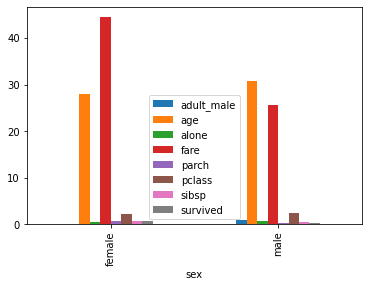

In [58]:
import matplotlib.pyplot as plt
gender.plot(kind='bar');

Well, the female passengers paid remarkably more for the tickets than the male passengers.



In [60]:
titanic.pivot_table(titanic,index=['sex','pclass'])

adult_male        age     alone        fare     parch  \
sex    pclass                                                          
female 1         0.000000  34.611765  0.361702  106.125798  0.457447   
       2         0.000000  28.722973  0.421053   21.970121  0.605263   
       3         0.000000  21.750000  0.416667   16.118810  0.798611   
male   1         0.975410  41.281386  0.614754   67.226127  0.278689   
       2         0.916667  30.740707  0.666667   19.741782  0.222222   
       3         0.919308  26.507589  0.760807   12.661633  0.224784   

                  sibsp  survived  
sex    pclass                      
female 1       0.553191  0.968085  
       2       0.486842  0.921053  
       3       0.895833  0.500000  
male   1       0.311475  0.368852  
       2       0.342593  0.157407  
       3       0.498559  0.135447

https://www.dataquest.io/blog/pandas-pivot-table/

https://towardsdatascience.com/30-days-of-pandas-in-an-article-b328cfb83d50

https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html#Pivot-Table-Syntax

https://www.machinelearningplus.com/pandas/pandas-pivot-table-in-python/